In [1]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.inspection import partial_dependence, PartialDependenceDisplay

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import graphviz

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

from data.get_data import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
start = "2021"
end = "2023"
data = get_data('BTC', '1d').loc[start : end]
data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)
data.shape

(814, 5)

<Axes: >

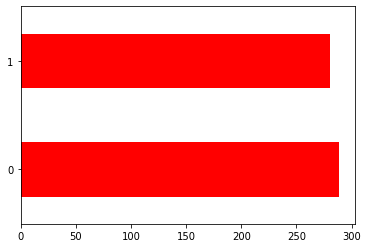

In [3]:
from preprocessing.function import *

N = data.shape[0]
n = int(0.7*N)
train = data[:n]
test = data[n:]


target = get_classification_target(train)
features = train

target_test = get_classification_target(test)
features_test = test

target.value_counts().plot(kind = 'barh', color = 'red')

In [4]:
from sklearn.model_selection import TimeSeriesSplit
cv  = TimeSeriesSplit(n_splits = 10)

In [5]:
model = DecisionTreeClassifier()
model.fit(features, target)

DecisionTreeClassifier()

 Accuracy : 0.5959183673469388 
 f1 : 0.31724137931034485 
 precision : 0.71875 
 recall : 0.20353982300884957 
 AUC : 0.5676790024135158 
              precision    recall  f1-score   support

           0       0.58      0.93      0.71       132
           1       0.72      0.20      0.32       113

    accuracy                           0.60       245
   macro avg       0.65      0.57      0.52       245
weighted avg       0.64      0.60      0.53       245



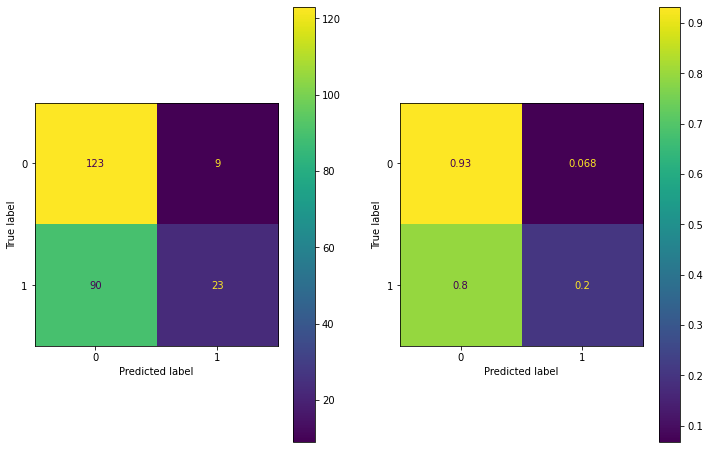

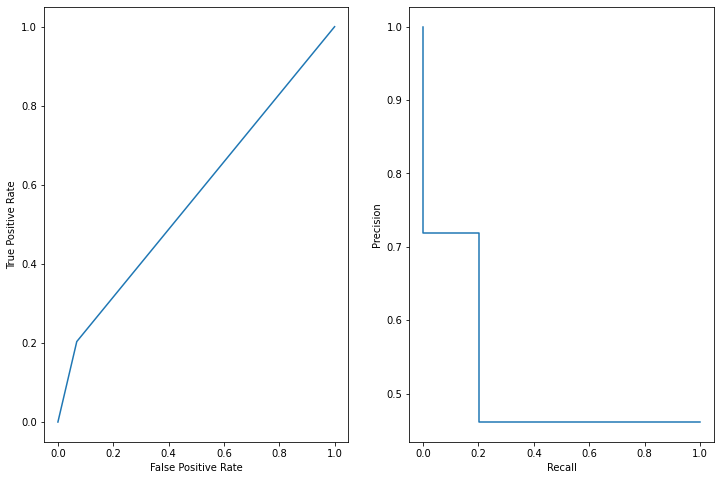

In [6]:
y_pred = model.predict(test)
y_pred_proba = model.predict_proba(test)

from evaluation.classification import *

evaluation = Evaluation(y_true = target_test, y_pred = y_pred, proba_pred = y_pred_proba[:,1])
evaluation.metrics()
evaluation.show()

<Axes: >

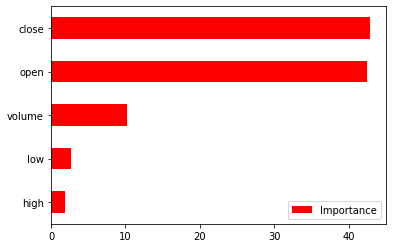

In [7]:
Importance = pd.DataFrame({'Importance' : model.feature_importances_*100},
                          index = model.feature_names_in_)
Importance.sort_values('Importance', axis = 0, ascending = True).plot(kind = 'barh', color = 'r')

# HyperParametrisation

In [8]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

In [9]:
def run_cv(model, X, y, metrics, cv, fit_params = None):
    return cross_validate(estimator = model,
                          X = X, y = y,
                          scoring = list(metrics.keys()),
                          cv = cv, n_jobs = -1,
                          verbose = 1,
                          fit_params = fit_params
                          )

In [10]:
x = run_cv(model, X = features, y = target, metrics = metrics, cv = cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.7s finished


In [11]:
cv_df = pd.DataFrame(x)
cv_df.drop(columns = ['fit_time', 'score_time'], inplace = True)

In [12]:
import plotly.express as px

px.box(cv_df)

# Boosting

In [13]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

# GradientBoostingClassifier

In [14]:
gb_model = GradientBoostingClassifier(loss = 'log_loss',
                                      learning_rate = 0.1,
                                      n_estimators = 100
                                      )
gb_model.fit(features, target)

GradientBoostingClassifier()

 Accuracy : 0.6326530612244898 
 f1 : 0.5909090909090908 
 precision : 0.6074766355140186 
 recall : 0.5752212389380531 
 AUC : 0.6373357468490212 
              precision    recall  f1-score   support

           0       0.65      0.68      0.67       132
           1       0.61      0.58      0.59       113

    accuracy                           0.63       245
   macro avg       0.63      0.63      0.63       245
weighted avg       0.63      0.63      0.63       245



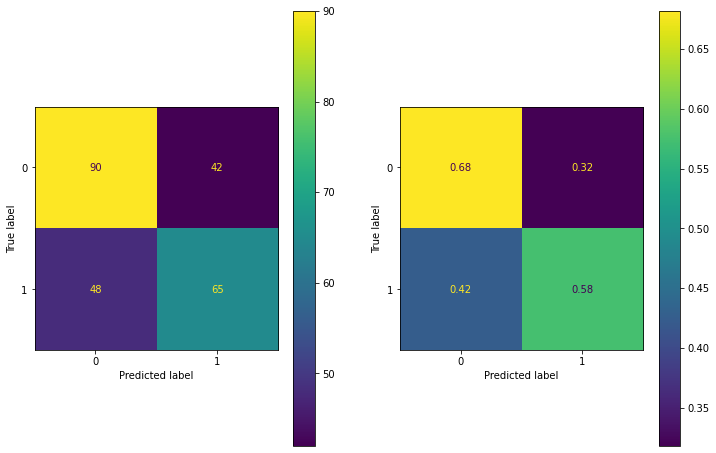

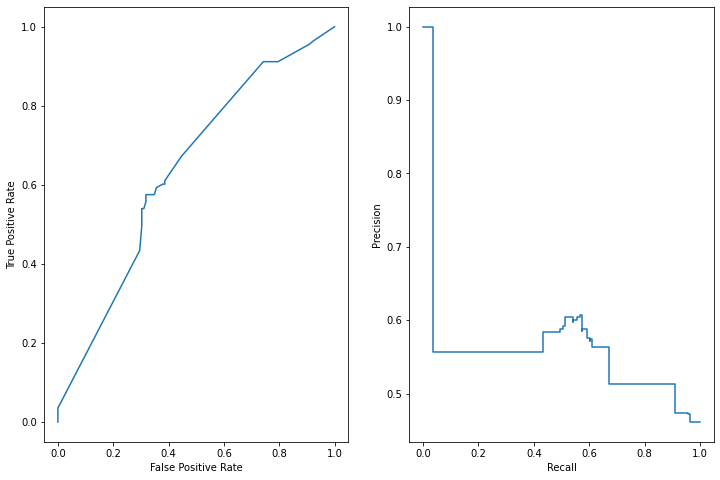

In [15]:
y_pred = gb_model.predict(test)
y_pred_proba = gb_model.predict_proba(test)

from evaluation.classification import *

evaluation = Evaluation(y_true = target_test, y_pred = y_pred, proba_pred = y_pred_proba[:,1])
evaluation.metrics()
evaluation.show()

<Axes: >

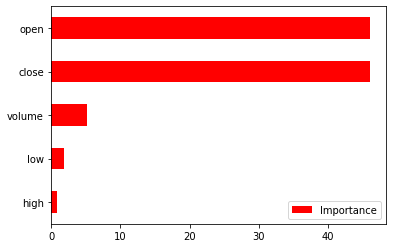

In [16]:
Importance = pd.DataFrame({'Importance' : gb_model.feature_importances_*100},
                          index = gb_model.feature_names_in_)
Importance.sort_values('Importance', axis = 0, ascending = True).plot(kind = 'barh', color = 'r')

In [17]:
param_grid = dict(
        learning_rate=[.01, .1, .2],
        max_depth=list(range(3, 13, 3)),
        max_features=['sqrt', .8, 1],
        min_impurity_decrease=[0, .01],
        min_samples_split=[10, 50],
        n_estimators=[100, 300],
        subsample=[.8, 1],
)

param_grid = dict(param_grid)

In [18]:
gs = GridSearchCV(gb_model,
                  param_grid,
                  cv=cv,
                  scoring='roc_auc',
                  verbose=3,
                  n_jobs=-1,
                  return_train_score=True)

gs.fit(features, target)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9, 12],
                         'max_features': ['sqrt', 0.8, 1],
                         'min_impurity_decrease': [0, 0.01],
                         'min_samples_split': [10, 50],
                         'n_estimators': [100, 300], 'subsample': [0.8, 1]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [19]:
gs.best_params_

{'learning_rate': 0.2,
 'max_depth': 9,
 'max_features': 0.8,
 'min_impurity_decrease': 0,
 'min_samples_split': 10,
 'n_estimators': 100,
 'subsample': 0.8}

In [20]:
gs.best_score_

0.8284908747661888

In [24]:
best_model = gs.best_estimator_
y_pred = best_model.predict(features_test)
metrics.roc_auc_score(y_true = target_test, y_score = y_pred)

0.6600294985250739

<Axes: >

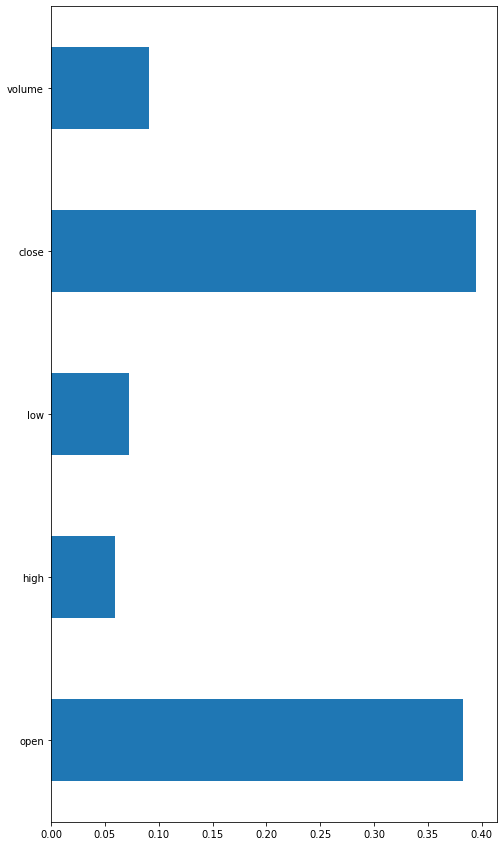

In [25]:
pd.Series(best_model.feature_importances_, index=model.feature_names_in_).plot.barh(figsize=(8,15))

In [38]:
results = pd.DataFrame(gs.cv_results_).drop('params', axis = 1)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_features,param_min_impurity_decrease,param_min_samples_split,param_n_estimators,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.561095,0.119684,0.019300,0.026468,0.01,3,sqrt,0,10,100,...,0.986647,0.964219,0.964319,0.956157,0.949799,0.947820,0.942333,0.932163,0.962093,0.019671
1,0.362398,0.044506,0.011601,0.016166,0.01,3,sqrt,0,10,100,...,0.965730,0.960392,0.965938,0.953398,0.955203,0.949854,0.943700,0.936442,0.960198,0.016692
2,1.209897,0.331843,0.013602,0.017830,0.01,3,sqrt,0,10,300,...,0.994134,0.993235,0.991615,0.987827,0.985438,0.978042,0.979787,0.975075,0.988316,0.008134
3,1.148098,0.147244,0.009800,0.010486,0.01,3,sqrt,0,10,300,...,0.995986,0.993502,0.990342,0.988598,0.984012,0.984571,0.975633,0.974411,0.988407,0.008299
4,0.388898,0.103336,0.012001,0.011172,0.01,3,sqrt,0,50,100,...,0.953535,0.937739,0.935028,0.929499,0.934036,0.922268,0.916746,0.922920,0.888247,0.129772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,0.654884,0.080544,0.007706,0.001719,0.2,12,1,0.01,10,300,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
572,0.336063,0.071791,0.007861,0.002773,0.2,12,1,0.01,50,100,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.950000,0.150000
573,0.311404,0.077226,0.007908,0.001832,0.2,12,1,0.01,50,100,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
574,0.757209,0.119540,0.009555,0.002611,0.2,12,1,0.01,50,300,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.950000,0.150000


In [40]:
test_scores = results.filter(like='param').join(results[['mean_test_score']])
test_scores = test_scores.rename(columns={c: '_'.join(c.split('_')[1:]) for c in test_scores.columns})
test_scores

,learning_rate,max_depth,max_features,min_impurity_decrease,min_samples_split,n_estimators,subsample,test_score
0,0.01,3,sqrt,0,10,100,0.8,0.677508
1,0.01,3,sqrt,0,10,100,1,0.656182
2,0.01,3,sqrt,0,10,300,0.8,0.720019
3,0.01,3,sqrt,0,10,300,1,0.695253
4,0.01,3,sqrt,0,50,100,0.8,0.638324
...,...,...,...,...,...,...,...,...
571,0.2,12,1,0.01,10,300,1,0.732319
572,0.2,12,1,0.01,50,100,0.8,0.746596
573,0.2,12,1,0.01,50,100,1,0.704053
574,0.2,12,1,0.01,50,300,0.8,0.748479


In [41]:
test_scores = test_scores.set_index('test_score').stack().reset_index()
test_scores.columns= ['test_score', 'parameter', 'value']
test_scores.head()

,test_score,parameter,value
0,0.677508,learning_rate,0.01
1,0.677508,max_depth,3
2,0.677508,max_features,sqrt
3,0.677508,min_impurity_decrease,0
4,0.677508,min_samples_split,10


In [42]:
def get_test_scores(df):
    """Select parameter values and test scores"""
    data = df.filter(like='param').join(results[['mean_test_score']])
    return data.rename(columns={c: '_'.join(c.split('_')[1:]) for c in data.columns})

In [43]:
plot_data = get_test_scores(results).drop('min_impurity_decrease', axis=1)
plot_params = plot_data.columns[:-1].tolist()
plot_data

,learning_rate,max_depth,max_features,min_samples_split,n_estimators,subsample,test_score
0,0.01,3,sqrt,10,100,0.8,0.677508
1,0.01,3,sqrt,10,100,1,0.656182
2,0.01,3,sqrt,10,300,0.8,0.720019
3,0.01,3,sqrt,10,300,1,0.695253
4,0.01,3,sqrt,50,100,0.8,0.638324
...,...,...,...,...,...,...,...
571,0.2,12,1,10,300,1,0.732319
572,0.2,12,1,50,100,0.8,0.746596
573,0.2,12,1,50,100,1,0.704053
574,0.2,12,1,50,300,0.8,0.748479


c:\Users\cc\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

9.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\cc\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

29.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\cc\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

32.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\cc\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

13.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\cc\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

22.9% of the poin

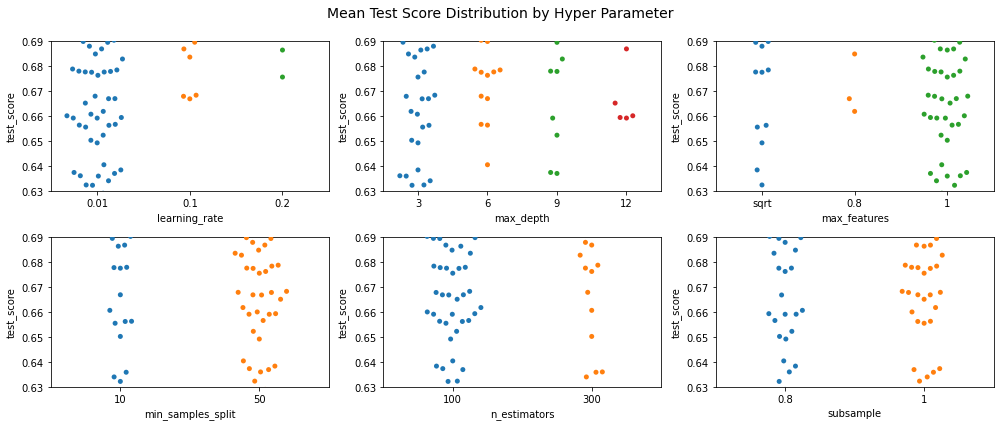

In [44]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 6))
axes = axes.flatten()

for i, param in enumerate(plot_params):
    sns.swarmplot(x=param, y='test_score', data=plot_data, ax=axes[i])
    axes[i].set_ylim(.63, .69)
    
fig.suptitle('Mean Test Score Distribution by Hyper Parameter', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('mean_test_scores_by_param', dpi=300);

In [45]:
data = get_test_scores(results)
params = data.columns[:-1].tolist()
data = pd.get_dummies(data,columns=params, drop_first=False)
data

C:\Users\cc\AppData\Local\Temp/ipykernel_329440/1775144870.py:3: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

C:\Users\cc\AppData\Local\Temp/ipykernel_329440/1775144870.py:3: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

C:\Users\cc\AppData\Local\Temp/ipykernel_329440/1775144870.py:3: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

C:\Users\cc\AppData\Local\Temp/ipykernel_329440/1775144870.py:3: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

C:\Users\cc\AppData\Local\Temp/ipykernel_329440/1775144870.py:3: FutureWarning:

In a future version, the Index constructor will not

,test_score,learning_rate_0.01,learning_rate_0.1,learning_rate_0.2,max_depth_3,max_depth_6,max_depth_9,max_depth_12,max_features_0.8,max_features_1,max_features_sqrt,min_impurity_decrease_0.0,min_impurity_decrease_0.01,min_samples_split_10,min_samples_split_50,n_estimators_100,n_estimators_300,subsample_0.8,subsample_1.0
0,0.677508,1,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0
1,0.656182,1,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,1
2,0.720019,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,1,0
3,0.695253,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,1
4,0.638324,1,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,0.732319,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1
572,0.746596,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0
573,0.704053,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1
574,0.748479,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,1,0


In [51]:
from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(criterion='poisson',
                                 splitter='best',
                                 max_depth=4,
                                 min_samples_split=5,
                                 min_samples_leaf=10,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=42,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 )



gbm_features = data.drop('test_score', axis=1).columns
reg_tree.fit(X=data[gbm_features], y=data.test_score)

DecisionTreeRegressor(criterion='poisson', max_depth=4, min_samples_leaf=10,
                      min_samples_split=5, random_state=42)

In [60]:
from pathlib import Path

out_file = 'gbm_sklearn_tree.dot'
dot_data = export_graphviz(reg_tree,
                          out_file=out_file,
                          feature_names=gbm_features,
                          max_depth=4,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

#graphviz.Source(dot_data)

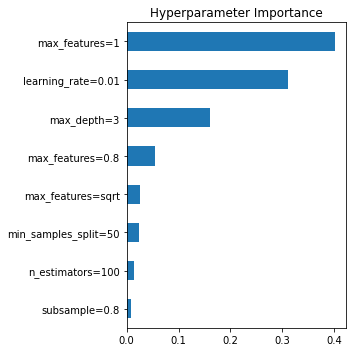

In [62]:
gbm_fi = pd.Series(reg_tree.feature_importances_, index=gbm_features).sort_values(ascending=False)
gbm_fi = gbm_fi[gbm_fi > 0]
idx = [p.split('_') for p in gbm_fi.index]
gbm_fi.index = ['_'.join(p[:-1]) + '=' + p[-1] for p in idx]
gbm_fi.sort_values().plot.barh(figsize=(5,5))
plt.title('Hyperparameter Importance')
plt.tight_layout()
plt.savefig('param_importance', dpi=300);

In [64]:
from statsmodels.api import OLS, add_constant

data = get_test_scores(results)
params = data.columns[:-1].tolist()
data = pd.get_dummies(data,columns=params, drop_first=True)

model = OLS(endog=data.test_score, exog=add_constant(data.drop('test_score', axis=1))).fit(cov_type='HC3')
print(model.summary())

C:\Users\cc\AppData\Local\Temp/ipykernel_329440/3099903202.py:5: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

C:\Users\cc\AppData\Local\Temp/ipykernel_329440/3099903202.py:5: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

C:\Users\cc\AppData\Local\Temp/ipykernel_329440/3099903202.py:5: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

C:\Users\cc\AppData\Local\Temp/ipykernel_329440/3099903202.py:5: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

C:\Users\cc\AppData\Local\Temp/ipykernel_329440/3099903202.py:5: FutureWarning:

In a future version, the Index constructor will not

                            OLS Regression Results                            
Dep. Variable:             test_score   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     185.7
Date:                Thu, 30 Mar 2023   Prob (F-statistic):          2.35e-179
Time:                        14:04:54   Log-Likelihood:                 1489.7
No. Observations:                 576   AIC:                            -2955.
Df Residuals:                     564   BIC:                            -2903.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               